# CS 171 Final Project — Awards Analysis and Visualization Notebook

Goal: Use the trained clustering model on player stats to:

- Visualize offensive and defensive "star tiers"
- Visualize MVP, DPOY, and Sixth Man candidates
- Visualize All-NBA and All-Defensive teams
- Show All-Star selections by conference

This notebook uses:

- `pandas`, `numpy`
- `StandardScaler` and `KMeans` from scikit-learn (Clustering lecture)
- `matplotlib` for plots

Data:

- `players_25_26_awards_clean.csv`


## Interpretation Summary

In the report, we can now discuss:

- How KMeans grouped players into offensive and defensive tiers.
- How tier 0 corresponds to star-level performance in our features.
- How MVP, DPOY, and Sixth Man scores line up with basketball logic
  (scoring, defense, minutes).
- How the All-NBA and All-Defensive teams compare to expectations.
- How the All-Star rosters reflect the distribution of overall scores
  between East and West.

These plots and tables serve as evidence that our clustering-based
model is being applied to answer the question:

> "Based only on 2025–26 per-game stats, who should win the major
> NBA awards and which players deserve All-NBA, All-Defensive,
> and All-Star honors?"


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from IPython.display import display

pd.set_option("display.max_columns", 120)

DATA_DIR = "."
PLAYERS_PATH = f"{DATA_DIR}/players_25_26_awards_clean.csv"

players = pd.read_csv(PLAYERS_PATH)

print("Players shape:", players.shape)
players.head()


Players shape: (255, 38)


,Player,Age,Pos,Pos_simple,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional,Awards,PTS36,TRB36,AST36,STL36,BLK36,TOV36
0,Jalen Johnson,24.0,SF,F,ATL,20,20,34.9,8.4,15.5,0.539,1.7,4.0,0.413,6.7,11.5,0.583,0.592,4.9,6.2,0.789,1.3,8.8,10.0,7.3,1.6,0.4,3.3,2.1,23.2,johnsja05,NaN,23.931232,10.315186,7.530086,1.650430,0.412607,3.404011
1,Dyson Daniels,22.0,SG,G,ATL,22,22,33.8,4.6,9.5,0.488,0.2,1.4,0.161,4.4,8.1,0.545,0.500,0.8,1.4,0.548,2.2,4.3,6.5,6.0,2.3,0.4,2.3,2.5,10.3,daniedy01,NaN,10.970414,6.923077,6.390533,2.449704,0.426036,2.449704
2,Nickeil Alexander-Walker,27.0,SG,G,ATL,20,17,32.8,7.0,14.9,0.466,2.8,7.2,0.392,4.2,7.8,0.535,0.560,3.7,4.3,0.859,0.7,2.7,3.4,3.6,1.0,0.9,2.3,2.1,20.4,alexani01,NaN,22.390244,3.731707,3.951220,1.097561,0.987805,2.524390
3,Onyeka Okongwu,25.0,C,C,ATL,21,10,30.5,6.2,12.0,0.514,1.9,5.1,0.370,4.3,6.9,0.621,0.593,2.1,2.8,0.759,1.6,5.7,7.3,2.9,0.9,1.1,1.9,3.6,16.4,okongon01,NaN,19.357377,8.616393,3.422951,1.062295,1.298361,2.242623
4,Zaccharie Risacher,20.0,SF,F,ATL,19,19,24.7,4.5,10.0,0.453,1.5,4.8,0.308,3.1,5.2,0.586,0.526,0.9,1.4,0.630,0.6,2.0,2.6,1.5,1.1,0.7,0.8,2.1,11.4,risacza01,NaN,16.615385,3.789474,2.186235,1.603239,1.020243,1.165992


## Feature Groups and Standardization

We use the same feature groups as in the Model Construction notebook.

- Offensive features: scoring, shooting, playmaking, minutes
- Defensive features: rebounding, steals, blocks, fouls

We standardize these stats with `StandardScaler` to obtain z-scores.


In [17]:
offense_features = [
    "PTS", "PTS36",
    "AST", "AST36",
    "FG%", "3P", "3PA", "3P%", "FT", "FTA", "FT%",
    "MP"
]

defense_features = [
    "TRB", "TRB36",
    "STL", "STL36",
    "BLK", "BLK36",
    "DRB", "ORB",
    "PF"
]

offense_features = [c for c in offense_features if c in players.columns]
defense_features = [c for c in defense_features if c in players.columns]

print("Offensive features:", offense_features)
print("Defensive features:", defense_features)


Offensive features: ['PTS', 'PTS36', 'AST', 'AST36', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'MP']
Defensive features: ['TRB', 'TRB36', 'STL', 'STL36', 'BLK', 'BLK36', 'DRB', 'ORB', 'PF']


### Compute Z-scores

We standardize each feature group:

- fill missing values with column means,
- apply `StandardScaler`,
- store each standardized feature as a new column `off_*_z` or `def_*_z`.


In [18]:
def compute_z_scores(df, feature_list, prefix):
    X = df[feature_list].copy()
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    Z = scaler.fit_transform(X)
    
    for i, col in enumerate(feature_list):
        z_col = f"{prefix}_{col}_z"
        df[z_col] = Z[:, i]
        
    return Z, df

Z_off, players = compute_z_scores(players, offense_features, prefix="off")
Z_def, players = compute_z_scores(players, defense_features, prefix="def")

players.head()


,Player,Age,Pos,Pos_simple,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional,Awards,PTS36,TRB36,AST36,STL36,BLK36,TOV36,off_PTS_z,off_PTS36_z,off_AST_z,off_AST36_z,off_FG%_z,off_3P_z,off_3PA_z,off_3P%_z,off_FT_z,off_FTA_z,off_FT%_z,off_MP_z,def_TRB_z,def_TRB36_z,def_STL_z,def_STL36_z,def_BLK_z,def_BLK36_z,def_DRB_z,def_ORB_z,def_PF_z
0,Jalen Johnson,24.0,SF,F,ATL,20,20,34.9,8.4,15.5,0.539,1.7,4.0,0.413,6.7,11.5,0.583,0.592,4.9,6.2,0.789,1.3,8.8,10.0,7.3,1.6,0.4,3.3,2.1,23.2,johnsja05,NaN,23.931232,10.315186,7.530086,1.650430,0.412607,3.404011,1.533875,1.208322,2.232311,1.678406,0.817591,0.232321,-0.031475,0.687340,1.439644,1.527810,0.133180,1.427425,2.194048,1.294727,1.702226,0.752241,-0.246363,-0.473610,2.971882,0.081407,-0.226474
1,Dyson Daniels,22.0,SG,G,ATL,22,22,33.8,4.6,9.5,0.488,0.2,1.4,0.161,4.4,8.1,0.545,0.500,0.8,1.4,0.548,2.2,4.3,6.5,6.0,2.3,0.4,2.3,2.5,10.3,daniedy01,NaN,10.970414,6.923077,6.390533,2.449704,0.426036,2.449704,-0.435633,-1.161902,1.563646,1.147333,0.167030,-1.377514,-1.153395,-1.969017,-0.791196,-0.654266,-2.059309,1.247295,0.730311,0.133427,3.444470,2.325908,-0.246363,-0.452953,0.435071,1.085858,0.397859
2,Nickeil Alexander-Walker,27.0,SG,G,ATL,20,17,32.8,7.0,14.9,0.466,2.8,7.2,0.392,4.2,7.8,0.535,0.560,3.7,4.3,0.859,0.7,2.7,3.4,3.6,1.0,0.9,2.3,2.1,20.4,alexani01,NaN,22.390244,3.731707,3.951220,1.097561,0.987805,2.524390,1.106385,0.926512,0.329189,0.010525,-0.113604,1.412868,1.349350,0.465977,0.786715,0.664071,0.770002,1.083541,-0.566143,-0.959148,0.208874,-0.336285,0.848106,0.411262,-0.466906,-0.588228,-0.226474
3,Onyeka Okongwu,25.0,C,C,ATL,21,10,30.5,6.2,12.0,0.514,1.9,5.1,0.370,4.3,6.9,0.621,0.593,2.1,2.8,0.759,1.6,5.7,7.3,2.9,0.9,1.1,1.9,3.6,16.4,okongon01,NaN,19.357377,8.616393,3.422951,1.062295,1.298361,2.242623,0.495685,0.371873,-0.030861,-0.235667,0.498688,0.446966,0.443184,0.234073,-0.083857,-0.017827,-0.139744,0.706906,1.064879,0.713139,-0.040018,-0.405719,1.285893,0.889014,1.224301,0.416224,2.114774
4,Zaccharie Risacher,20.0,SF,F,ATL,19,19,24.7,4.5,10.0,0.453,1.5,4.8,0.308,3.1,5.2,0.586,0.526,0.9,1.4,0.630,0.6,2.0,2.6,1.5,1.1,0.7,0.8,2.1,11.4,risacza01,NaN,16.615385,3.789474,2.186235,1.603239,1.020243,1.165992,-0.267690,-0.129572,-0.750962,-0.812022,-0.279434,0.017677,0.313731,-0.419475,-0.736785,-0.654266,-1.313317,-0.242870,-0.900711,-0.939372,0.457766,0.659329,0.410318,0.461164,-0.861521,-0.699834,-0.226474


## Scores and KMeans Tiers

We compute:

- `off_score` = mean of offensive z-features
- `def_score` = mean of defensive z-features
- `overall_score` = 0.6 * off_score + 0.4 * def_score

We then train two KMeans models (k = 3):

- Offensive KMeans on offensive z-features
- Defensive KMeans on defensive z-features

We map clusters so that tier 0 is always the strongest cluster
(highest mean score).


In [19]:
off_z_cols = [c for c in players.columns if c.startswith("off_") and c.endswith("_z")]
def_z_cols = [c for c in players.columns if c.startswith("def_") and c.endswith("_z")]

players["off_score"] = players[off_z_cols].mean(axis=1)
players["def_score"] = players[def_z_cols].mean(axis=1)
players["overall_score"] = 0.6 * players["off_score"] + 0.4 * players["def_score"]

k_off = 3
k_def = 3

kmeans_off = KMeans(n_clusters=k_off, random_state=0, n_init=10)
off_clusters = kmeans_off.fit_predict(Z_off)

kmeans_def = KMeans(n_clusters=k_def, random_state=0, n_init=10)
def_clusters = kmeans_def.fit_predict(Z_def)

players["off_cluster_raw"] = off_clusters
players["def_cluster_raw"] = def_clusters

off_cluster_means = players.groupby("off_cluster_raw")["off_score"].mean()
def_cluster_means = players.groupby("def_cluster_raw")["def_score"].mean()

off_cluster_order = off_cluster_means.sort_values(ascending=False).index.tolist()
def_cluster_order = def_cluster_means.sort_values(ascending=False).index.tolist()

off_cluster_to_tier = {cluster: tier for tier, cluster in enumerate(off_cluster_order)}
def_cluster_to_tier = {cluster: tier for tier, cluster in enumerate(def_cluster_order)}

players["off_tier"] = players["off_cluster_raw"].map(off_cluster_to_tier)
players["def_tier"] = players["def_cluster_raw"].map(def_cluster_to_tier)

players[["Player","Tm","Pos_simple","off_score","off_tier","def_score","def_tier","overall_score"]].head(10)


C:\Users\hassa\miniconda3\envs\cs171\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hassa\miniconda3\envs\cs171\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Player,Tm,Pos_simple,off_score,off_tier,def_score,def_tier,overall_score
0,Jalen Johnson,ATL,F,1.073896,0,0.894454,0,1.002119
1,Dyson Daniels,ATL,G,-0.456411,2,0.872621,1,0.075202
2,Nickeil Alexander-Walker,ATL,G,0.732628,0,-0.186105,2,0.365135
3,Onyeka Okongwu,ATL,C,0.224118,1,0.806943,0,0.457248
4,Zaccharie Risacher,ATL,F,-0.439582,1,-0.182148,1,-0.336609
5,Vit Krejci,ATL,G,-0.165815,1,-0.700082,2,-0.379522
6,Luke Kennard,ATL,G,-0.238654,1,-0.859300,2,-0.486912
7,Mouhamed Gueye,ATL,F,-0.969085,2,-0.058941,2,-0.605028
8,Jaylen Brown,BOS,F,1.066620,0,0.240960,1,0.736356
9,Derrick White,BOS,G,0.501502,1,0.392523,1,0.457910


## Roles and Minutes

We reuse the starter/bench logic and add a z-score for minutes.

- `start_rate` = GS / G
- `is_starter` = start_rate at least 0.5
- `is_bench`   = start_rate at most 0.4
- `MP_z`       = standardized minutes per game


In [20]:
players["start_rate"] = players["GS"] / players["G"]
players["is_starter"] = players["start_rate"] >= 0.5
players["is_bench"]   = players["start_rate"] <= 0.4

mp_scaler = StandardScaler()
mp_z = mp_scaler.fit_transform(players[["MP"]].fillna(players["MP"].mean()))
players["MP_z"] = mp_z[:, 0]

players[["Player","Tm","G","GS","start_rate","is_starter","is_bench","MP","MP_z"]].head()


,Player,Tm,G,GS,start_rate,is_starter,is_bench,MP,MP_z
0,Jalen Johnson,ATL,20,20,1.00000,True,False,34.9,1.427425
1,Dyson Daniels,ATL,22,22,1.00000,True,False,33.8,1.247295
2,Nickeil Alexander-Walker,ATL,20,17,0.85000,True,False,32.8,1.083541
3,Onyeka Okongwu,ATL,21,10,0.47619,False,False,30.5,0.706906
4,Zaccharie Risacher,ATL,19,19,1.00000,True,False,24.7,-0.242870


## Distribution of Overall Impact

We first look at the distribution of `overall_score` learned by the model.


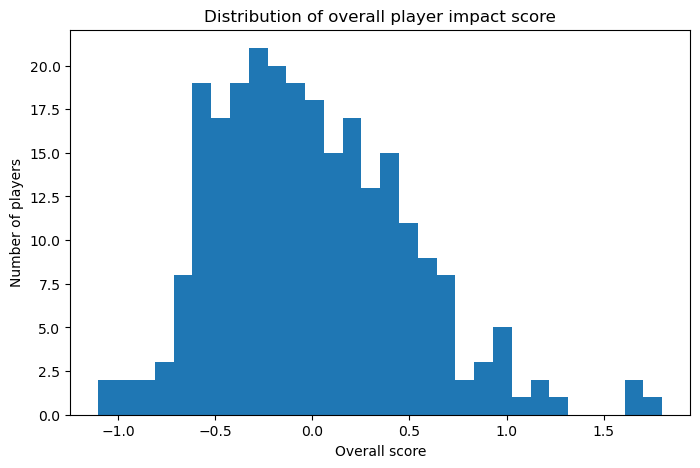

In [21]:
plt.figure(figsize=(8,5))
plt.hist(players["overall_score"], bins=30)
plt.xlabel("Overall score")
plt.ylabel("Number of players")
plt.title("Distribution of overall player impact score")
plt.show()


## Offensive vs Defensive Impact

We plot each player in offensive vs defensive score space.

- x-axis: offensive score
- y-axis: defensive score
- color: offensive tier (0 = strongest)
- size: minutes per game

This shows offensive stars, defensive specialists, and balanced players.


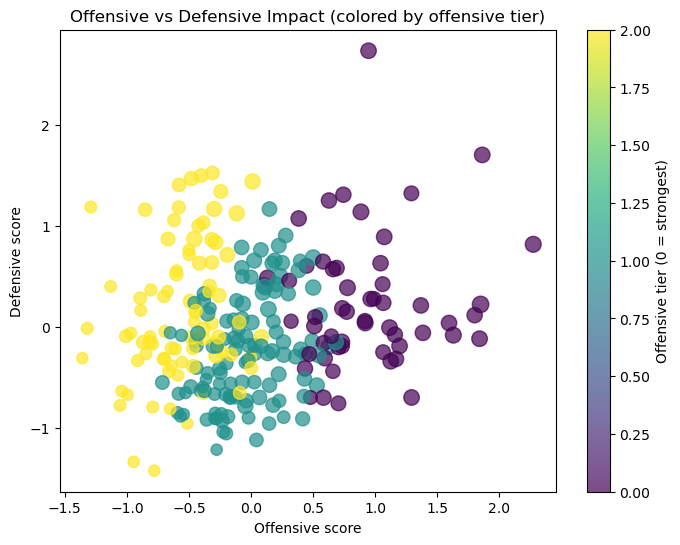

In [22]:
plt.figure(figsize=(8,6))

sizes = 20 + 3 * players["MP"]

scatter = plt.scatter(
    players["off_score"],
    players["def_score"],
    c=players["off_tier"],
    s=sizes,
    alpha=0.7
)

plt.xlabel("Offensive score")
plt.ylabel("Defensive score")
plt.title("Offensive vs Defensive Impact (colored by offensive tier)")
plt.colorbar(scatter, label="Offensive tier (0 = strongest)")
plt.show()


## Average Scores by Tier

We verify that tier 0 really is the "star" cluster by checking average
scores by offensive and defensive tier.


Average scores by offensive tier:


,off_score,def_score,overall_score
off_tier,,,
0,0.934502,0.234119,0.654349
1,-0.039832,-0.220380,-0.112051
2,-0.557599,0.165644,-0.268301


Average scores by defensive tier:


,off_score,def_score,overall_score
def_tier,,,
0,-0.040576,0.867263,0.322560
1,0.194096,0.129559,0.168281
2,-0.103878,-0.479858,-0.254270


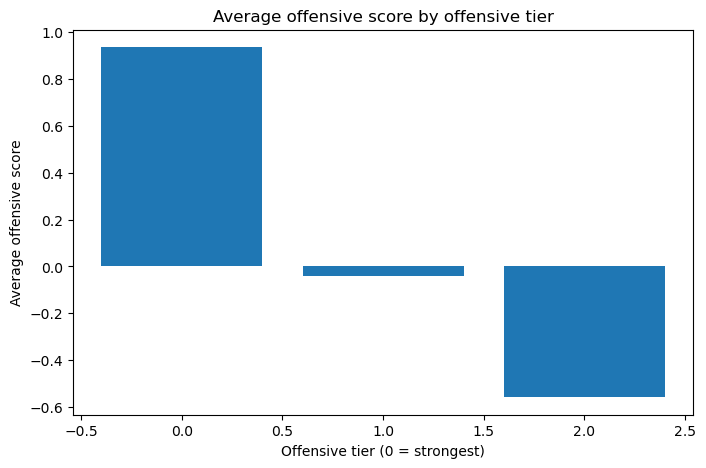

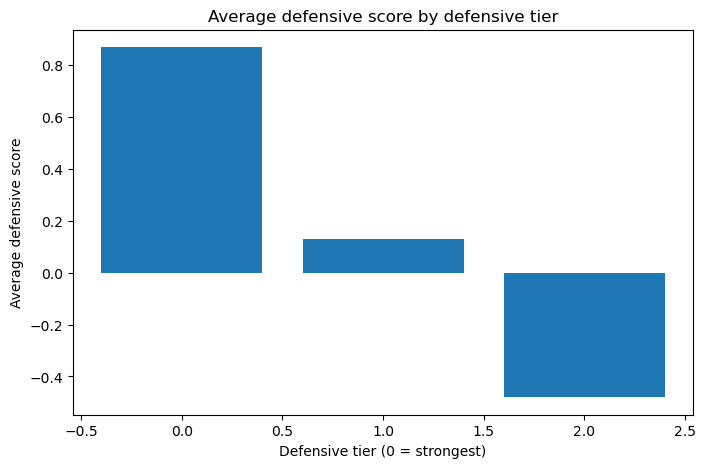

In [23]:
tier_off_means = players.groupby("off_tier")[["off_score","def_score","overall_score"]].mean()
tier_def_means = players.groupby("def_tier")[["off_score","def_score","overall_score"]].mean()

print("Average scores by offensive tier:")
display(tier_off_means)

print("Average scores by defensive tier:")
display(tier_def_means)

plt.figure(figsize=(8,5))
plt.bar(tier_off_means.index, tier_off_means["off_score"])
plt.xlabel("Offensive tier (0 = strongest)")
plt.ylabel("Average offensive score")
plt.title("Average offensive score by offensive tier")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(tier_def_means.index, tier_def_means["def_score"])
plt.xlabel("Defensive tier (0 = strongest)")
plt.ylabel("Average defensive score")
plt.title("Average defensive score by defensive tier")
plt.show()


## Award Scores

We reconstruct the award scores:

- `mvp_score`  = 0.7 * off_score + 0.3 * def_score + 0.2 * MP_z
- `dpoy_score` = def_score + 0.2 * MP_z
- `sixth_score` = off_score + 0.1 * def_score

We now visualize top candidates, using the **same MP-based eligibility** as
the Model Construction notebook.


In [24]:
players["mvp_score"]   = 0.7 * players["off_score"] + 0.3 * players["def_score"] + 0.2 * players["MP_z"]
players["dpoy_score"]  = players["def_score"] + 0.2 * players["MP_z"]
players["sixth_score"] = players["off_score"] + 0.1 * players["def_score"]


### MVP Candidates (Top 10)

Eligibility:

- starter (`is_starter == True`)
- offensive tier 0 or 1
- at least 20 minutes per game (`MP >= 20`)


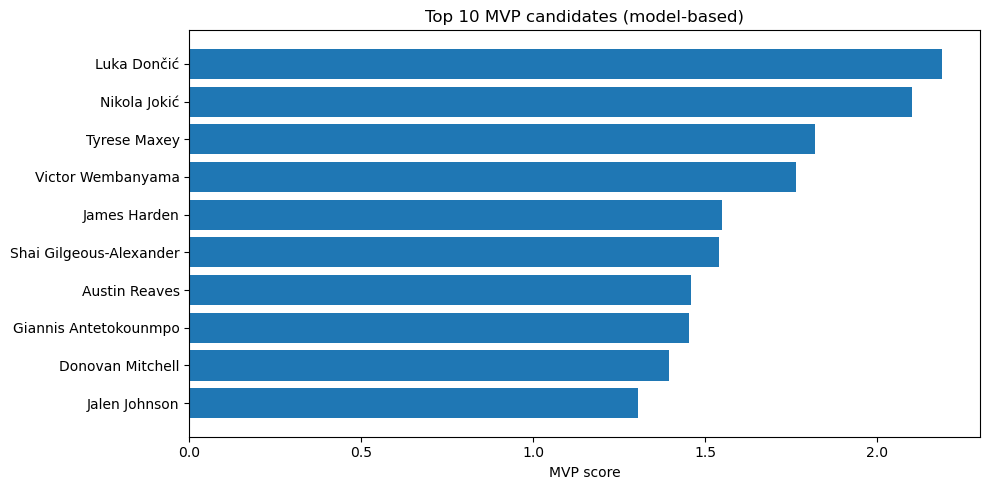

,Player,Tm,Pos_simple,G,MP,PTS,off_score,def_score,mvp_score
97,Luka Dončić,LAL,G,16,36.9,35.3,2.274940,0.820716,2.189660
62,Nikola Jokić,DEN,C,20,34.9,29.0,1.863910,1.706229,2.102091
178,Tyrese Maxey,PHI,G,20,40.1,32.5,1.850497,0.225409,1.818760
216,Victor Wembanyama,SAS,C,12,34.7,26.2,0.947584,2.738238,1.763715
89,James Harden,LAC,G,20,35.1,26.9,1.842441,-0.114272,1.547462
160,Shai Gilgeous-Alexander,OKC,G,22,33.6,32.8,1.802525,0.118836,1.540327
98,Austin Reaves,LAL,G,17,36.6,28.1,1.630834,-0.078870,1.459084
126,Giannis Antetokounmpo,MIL,F,16,30.8,30.6,1.293037,1.325579,1.454006
43,Donovan Mitchell,CLE,G,20,34.3,30.6,1.596057,0.041443,1.395507
0,Jalen Johnson,ATL,F,20,34.9,23.2,1.073896,0.894454,1.305548


In [25]:
mvp_candidates = players[
    (players["is_starter"]) &
    (players["off_tier"] <= 1) &
    (players["MP"] >= 20)
].copy()

if mvp_candidates.empty:
    mvp_candidates = players.copy()

top_mvp = mvp_candidates.sort_values("mvp_score", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_mvp["Player"][::-1], top_mvp["mvp_score"][::-1])
plt.xlabel("MVP score")
plt.title("Top 10 MVP candidates (model-based)")
plt.tight_layout()
plt.show()

top_mvp[["Player","Tm","Pos_simple","G","MP","PTS","off_score","def_score","mvp_score"]]


### DPOY Candidates (Top 10)

Eligibility:

- at least 20 minutes per game (`MP >= 20`)

We sort by `dpoy_score` and show the top 10.


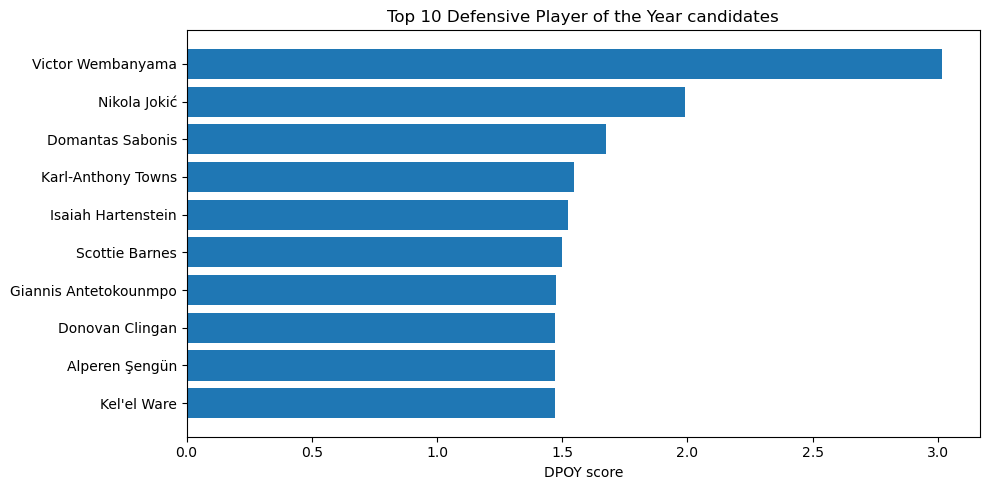

,Player,Tm,Pos_simple,G,MP,TRB,STL,BLK,def_score,dpoy_score
216,Victor Wembanyama,SAS,C,12,34.7,12.9,1.1,3.6,2.738238,3.017172
62,Nikola Jokić,DEN,C,20,34.9,12.8,1.5,0.8,1.706229,1.991715
207,Domantas Sabonis,SAC,C,11,33.2,12.3,1.2,0.2,1.443359,1.673168
153,Karl-Anthony Towns,NYK,C,20,33.4,11.7,0.8,0.8,1.312086,1.548445
164,Isaiah Hartenstein,OKC,C,19,27.8,10.7,1.3,0.8,1.471493,1.524446
227,Scottie Barnes,TOR,F,22,33.6,7.9,1.4,1.6,1.254664,1.497573
126,Giannis Antetokounmpo,MIL,F,16,30.8,10.7,1.0,1.0,1.325579,1.476785
202,Donovan Clingan,POR,C,20,25.3,10.1,0.7,1.5,1.501222,1.472298
71,Alperen Şengün,HOU,C,18,36.2,9.1,1.2,1.1,1.141604,1.469665
120,Kel'el Ware,MIA,C,21,24.4,10.6,1.0,1.3,1.527440,1.469041


In [26]:
dpoy_candidates = players[players["MP"] >= 20].copy()

if dpoy_candidates.empty:
    dpoy_candidates = players.copy()

top_dpoy = dpoy_candidates.sort_values("dpoy_score", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_dpoy["Player"][::-1], top_dpoy["dpoy_score"][::-1])
plt.xlabel("DPOY score")
plt.title("Top 10 Defensive Player of the Year candidates")
plt.tight_layout()
plt.show()

top_dpoy[["Player","Tm","Pos_simple","G","MP","TRB","STL","BLK","def_score","dpoy_score"]]


### Sixth Man Candidates (Top 10)

Eligibility:

- bench players (`is_bench == True`)
- at least 18 minutes per game (`MP >= 18`)


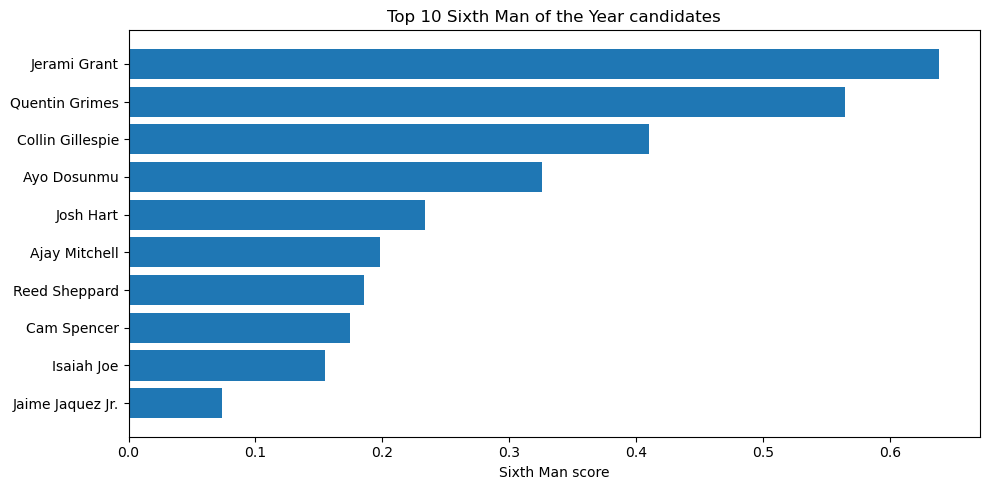

,Player,Tm,Pos_simple,G,MP,PTS,off_score,sixth_score
200,Jerami Grant,POR,F,20,29.2,19.1,0.648043,0.639127
181,Quentin Grimes,PHI,G,19,33.1,17.0,0.595124,0.564313
192,Collin Gillespie,PHX,G,22,26.8,13.4,0.436586,0.410084
30,Ayo Dosunmu,CHI,G,18,27.4,15.8,0.416833,0.326050
155,Josh Hart,NYK,F,19,28.8,11.8,0.170671,0.233930
165,Ajay Mitchell,OKC,G,22,26.7,15.0,0.203416,0.198536
74,Reed Sheppard,HOU,G,18,25.2,13.7,0.180217,0.185864
114,Cam Spencer,MEM,G,22,20.4,10.8,0.263528,0.174430
167,Isaiah Joe,OKC,G,17,23.4,12.9,0.227768,0.154843
119,Jaime Jaquez Jr.,MIA,F,20,29.3,15.6,0.083038,0.073402


In [27]:
sixth_candidates = players[
    (players["is_bench"]) &
    (players["MP"] >= 18)
].copy()

if sixth_candidates.empty:
    sixth_candidates = players[players["is_bench"]].copy()

top_sixth = sixth_candidates.sort_values("sixth_score", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_sixth["Player"][::-1], top_sixth["sixth_score"][::-1])
plt.xlabel("Sixth Man score")
plt.title("Top 10 Sixth Man of the Year candidates")
plt.tight_layout()
plt.show()

top_sixth[["Player","Tm","Pos_simple","G","MP","PTS","off_score","sixth_score"]]


## All-NBA and All-Defensive Teams

We rebuild the All-NBA and All-Defensive teams with the same logic
as the Model Construction notebook, then visualize scores.


In [28]:
def build_team(sorted_df, taken_players, g_needed=2, f_needed=2, c_needed=1):
    team = []

    def pick(pos, n):
        nonlocal team, taken_players
        candidates = sorted_df[
            (sorted_df["Pos_simple"] == pos) &
            (~sorted_df["Player"].isin(taken_players))
        ]
        chosen = candidates.head(n)
        team.append(chosen)
        taken_players.update(chosen["Player"].tolist())

    pick("G", g_needed)
    pick("F", f_needed)
    pick("C", c_needed)

    if team:
        return pd.concat(team)
    else:
        return pd.DataFrame(columns=sorted_df.columns)


All-NBA First Team:


,Player,Tm,Pos_simple,overall_score
97,Luka Dončić,LAL,G,1.693250
178,Tyrese Maxey,PHI,G,1.200462
126,Giannis Antetokounmpo,MIL,F,1.306054
0,Jalen Johnson,ATL,F,1.002119
62,Nikola Jokić,DEN,C,1.800838


All-NBA Second Team:


,Player,Tm,Pos_simple,overall_score
160,Shai Gilgeous-Alexander,OKC,G,1.129049
89,James Harden,LAC,G,1.059756
197,Deni Avdija,POR,F,0.907835
227,Scottie Barnes,TOR,F,0.879021
216,Victor Wembanyama,SAS,C,1.663845


All-NBA Third Team:


,Player,Tm,Pos_simple,overall_score
43,Donovan Mitchell,CLE,G,0.974211
98,Austin Reaves,LAL,G,0.946952
91,Kawhi Leonard,LAC,F,0.807018
8,Jaylen Brown,BOS,F,0.736356
71,Alperen Şengün,HOU,C,0.988450


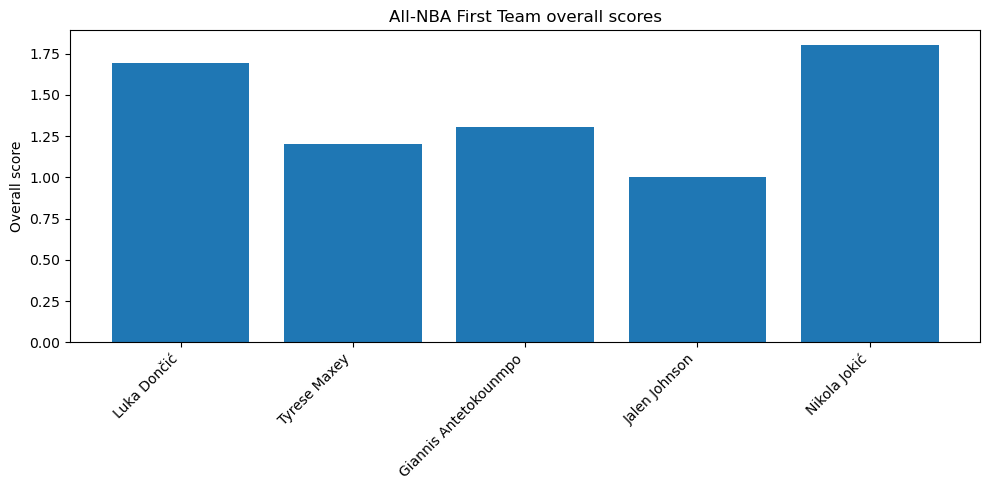

In [29]:
nba_pool = players[players["MP"] >= 20].copy()

if nba_pool.empty:
    nba_pool = players.copy()

nba_pool = nba_pool.sort_values("overall_score", ascending=False)

taken = set()
all_nba_first  = build_team(nba_pool, taken)
all_nba_second = build_team(nba_pool, taken)
all_nba_third  = build_team(nba_pool, taken)

print("All-NBA First Team:")
display(all_nba_first[["Player","Tm","Pos_simple","overall_score"]])

print("All-NBA Second Team:")
display(all_nba_second[["Player","Tm","Pos_simple","overall_score"]])

print("All-NBA Third Team:")
display(all_nba_third[["Player","Tm","Pos_simple","overall_score"]])

plt.figure(figsize=(10,5))
plt.bar(all_nba_first["Player"], all_nba_first["overall_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Overall score")
plt.title("All-NBA First Team overall scores")
plt.tight_layout()
plt.show()


All-Defensive First Team:


,Player,Tm,Pos_simple,def_score
1,Dyson Daniels,ATL,G,0.872621
97,Luka Dončić,LAL,G,0.820716
126,Giannis Antetokounmpo,MIL,F,1.325579
227,Scottie Barnes,TOR,F,1.254664
216,Victor Wembanyama,SAS,C,2.738238


All-Defensive Second Team:


,Player,Tm,Pos_simple,def_score
175,Jalen Suggs,ORL,G,0.656486
219,Stephon Castle,SAS,G,0.649563
44,Evan Mobley,CLE,F,1.076627
161,Chet Holmgren,OKC,F,0.908126
62,Nikola Jokić,DEN,C,1.706229


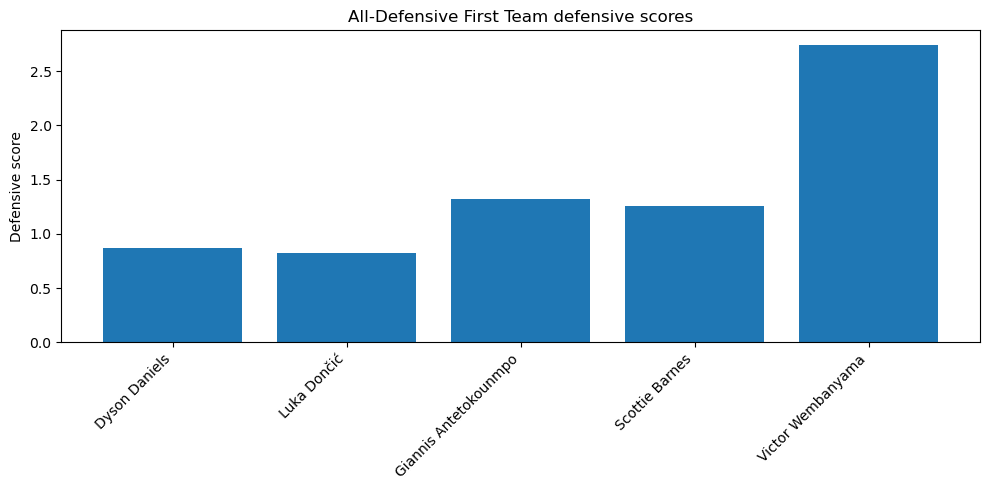

In [30]:
def_pool = players[players["MP"] >= 18].copy()

if def_pool.empty:
    def_pool = players.copy()

def_pool = def_pool.sort_values("def_score", ascending=False)

taken_def = set()
all_def_first  = build_team(def_pool, taken_def)
all_def_second = build_team(def_pool, taken_def)

print("All-Defensive First Team:")
display(all_def_first[["Player","Tm","Pos_simple","def_score"]])

print("All-Defensive Second Team:")
display(all_def_second[["Player","Tm","Pos_simple","def_score"]])

plt.figure(figsize=(10,5))
plt.bar(all_def_first["Player"], all_def_first["def_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Defensive score")
plt.title("All-Defensive First Team defensive scores")
plt.tight_layout()
plt.show()


## All-Star Selections by Conference

We select All-Stars using the same MP-based rule as the Model notebook.

Eligibility:

- at least 20 minutes per game
- known conference (East or West)

We take the top 12 players in each conference by `overall_score`.


East All-Stars:


,Player,Tm,Pos_simple,overall_score
126,Giannis Antetokounmpo,MIL,F,1.306054
178,Tyrese Maxey,PHI,G,1.200462
0,Jalen Johnson,ATL,F,1.002119
43,Donovan Mitchell,CLE,G,0.974211
153,Karl-Anthony Towns,NYK,C,0.971726
26,Josh Giddey,CHI,G,0.880130
227,Scottie Barnes,TOR,F,0.879021
8,Jaylen Brown,BOS,F,0.736356
37,LaMelo Ball,CHA,G,0.706596
44,Evan Mobley,CLE,F,0.661264


West All-Stars:


,Player,Tm,Pos_simple,overall_score
62,Nikola Jokić,DEN,C,1.800838
97,Luka Dončić,LAL,G,1.693250
216,Victor Wembanyama,SAS,C,1.663845
160,Shai Gilgeous-Alexander,OKC,G,1.129049
89,James Harden,LAC,G,1.059756
71,Alperen Şengün,HOU,C,0.988450
98,Austin Reaves,LAL,G,0.946952
197,Deni Avdija,POR,F,0.907835
133,Anthony Edwards,MIN,G,0.808861
91,Kawhi Leonard,LAC,F,0.807018


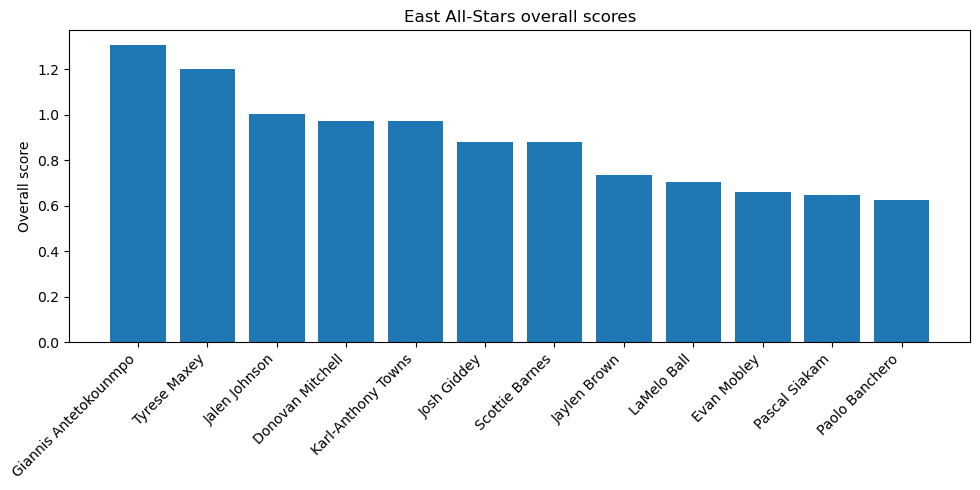

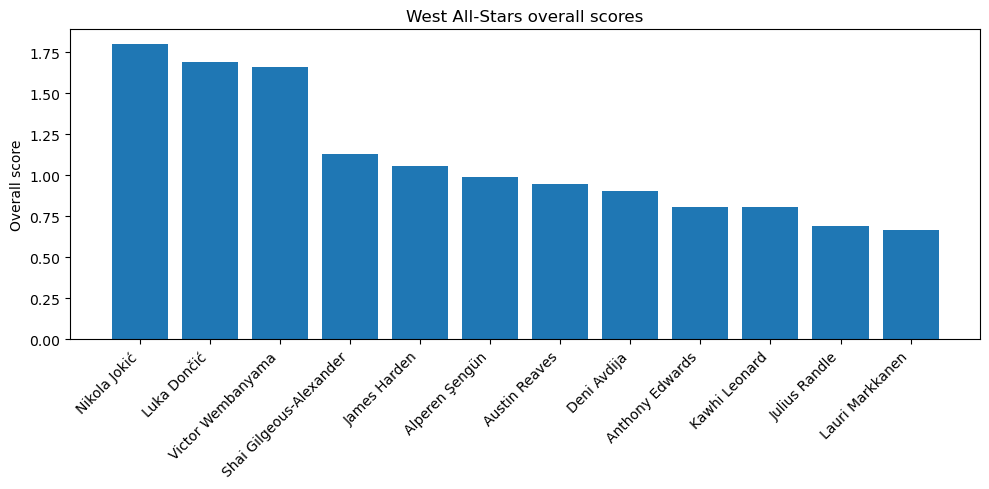

In [31]:
east_teams = ['ATL','BOS','BKN','CHA','CHI','CLE','DET','IND',
              'MIA','MIL','NYK','ORL','PHI','TOR','WAS']
west_teams = ['DAL','DEN','GSW','HOU','LAC','LAL','MEM','MIN',
              'NOP','OKC','PHX','POR','SAC','SAS','UTA']

players["Conference"] = np.where(
    players["Tm"].isin(east_teams), "East",
    np.where(players["Tm"].isin(west_teams), "West", "Unknown")
)

allstar_pool = players[
    (players["MP"] >= 20) &
    (players["Conference"] != "Unknown")
].copy()

if allstar_pool.empty:
    allstar_pool = players[players["Conference"] != "Unknown"].copy()

east_pool = allstar_pool[allstar_pool["Conference"]=="East"].sort_values("overall_score", ascending=False)
west_pool = allstar_pool[allstar_pool["Conference"]=="West"].sort_values("overall_score", ascending=False)

EAST_N = min(12, len(east_pool))
WEST_N = min(12, len(west_pool))

east_allstars = east_pool.head(EAST_N)
west_allstars = west_pool.head(WEST_N)

print("East All-Stars:")
display(east_allstars[["Player","Tm","Pos_simple","overall_score"]])

print("West All-Stars:")
display(west_allstars[["Player","Tm","Pos_simple","overall_score"]])

plt.figure(figsize=(10,5))
plt.bar(east_allstars["Player"], east_allstars["overall_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Overall score")
plt.title("East All-Stars overall scores")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(west_allstars["Player"], west_allstars["overall_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Overall score")
plt.title("West All-Stars overall scores")
plt.tight_layout()
plt.show()


## Interpretation Summary

This notebook shows the trained KMeans model in action:

- Offensive and defensive tiers separate star players from role players.
- MVP, DPOY, and Sixth Man awards are driven by model-based scores that
  combine offense, defense, and minutes.
- All-NBA and All-Defensive teams highlight players with the highest
  overall or defensive scores at each position.
- All-Star selections reflect the distribution of overall impact between
  the Eastern and Western conferences.

All eligibility rules are based on minutes per game (MP), which makes
sense for a partial 2025–26 season: we are rewarding players who have
a large enough role, regardless of how many games have been played so far.
